In [8]:
from model.GP_model import GP
import gpjax as gpx
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from math import ceil
import pandas as pd
import polars as pl

In [9]:
df = pl.read_parquet("./GP_data/cleaned_offline_dataset_daily_continuous.parquet")
# df = df.with_columns(
#        pl.col("clean_area").mean().over("experiment", "zone", "time").alias("mean_clean_area"),
#    )
# df = df.filter(pl.col("plant_id") == 0)
# df = df.with_columns(
#        pl.col("mean_clean_area").shift(-1).over("experiment", "zone").alias("next_mean_clean_area"),
#    )

df = df.with_columns(
    pl.col("clean_area")
    .shift(-1)
    .over("experiment", "zone", "plant_id")
    .alias("next_clean_area"),
)
# remove rows with truncated = true
df = df.filter(pl.col("truncated") == False)
# remove rows with null next_mean_clean_area
df = df.filter(pl.col("next_clean_area").is_not_null())

In [10]:
# create list of tuples with df col “mean_clean_area”, “red_coef”, “white_coef”, “blue_coef”, “red_coef_trace_0.5”, “white_coef_trace_0.5", “blue_coef_trace_0.5”
input_data = np.vstack(
    list(
        zip(
            df["clean_area"].to_list(),
            df["red_coef"].to_list(),
            df["white_coef"].to_list(),
            df["blue_coef"].to_list(),
            df["red_coef_trace_0.5"].to_list(),
            df["white_coef_trace_0.5"].to_list(),
            df["blue_coef_trace_0.5"].to_list(),
        )
    )
)
output_data = np.vstack(df["next_clean_area"].to_list())

In [12]:
len(output_data)

4497

In [13]:
GP_model = GP(input_data, output_data)  # , kernel = gpx.kernels.RBF())

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4095.886170
         Iterations: 23
         Function evaluations: 75
         Gradient evaluations: 64


In [ ]:
# import pickle

# with open(
#    f"./models/E13_every_size_1day_trace5.pickle", "wb"
# ) as f:
#    pickle.dump(GP_model, f)

In [ ]:
actions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_area = np.linspace(0, 1000, 100)
tests = [
    np.vstack([[area] + actions[i] + [0.33, 0.33, 0.33] for area in test_area])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/tmp/ipykernel_107827/3002964166.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


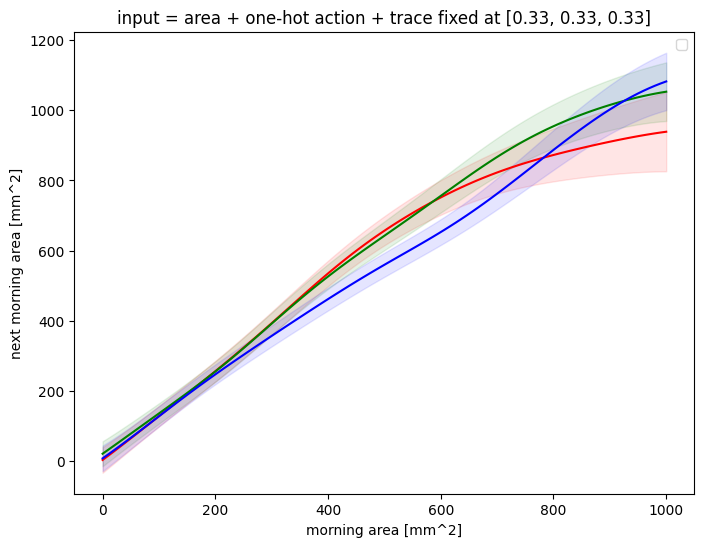

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
COLORS = ["r", "g", "b"]
for i in range(3):
    ax.plot(test_area, Mean[i], color=COLORS[i])
    ax.fill_between(
        test_area.squeeze(),
        Mean[i] - 1 * Std[i],
        Mean[i] + 1 * Std[i],
        alpha=0.1,
        color=COLORS[i],
    )
ax.set_xlabel("morning area [mm^2]")
ax.set_ylabel("next morning area [mm^2]")
ax.set_title(f"input = area + one-hot action + trace fixed at [0.33, 0.33, 0.33]")
# ax.set_title(f"input = area + one-hot action ")
ax.legend()
# ax.set_xlim([100, 1000])
# ax.set_ylim([100., 750])